Objective: Causal Analysis on Life Expectancy

The original dataset contains a lot of missing valus and incorrect information, which has been corrected in *'life-expectancy-prediction.ipynb'* in Asm 1.

This notebook uses the corrected dataset and applies the same data cleaning steps as Asm 1.

1. Identify Target, Control Features, Treatment Features
2. Experiment with LRSRegressor, XGRTRegressor + more
3. Plot Feature Importance
4. Analyst the result

In [1]:
# data processing libraries
import pandas as pd
import numpy as np

# modeling 
import sklearn
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.impute import SimpleImputer

# Algorithms
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, LassoCV

# Causal Inference
import causalml
from causalml.inference.meta import LRSRegressor, XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.dataset import *
from causalml.metrics import *

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5] #change size of plot
plt.style.use('fivethirtyeight')


# Handle warnings
import warnings
warnings.filterwarnings('ignore')

print(causalml.__version__)

C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


0.13.0


# 0) Life Expectancy Dataset 

In [2]:
df = pd.read_csv('new_LifeExp.csv')

In [3]:
df.head()

,Country,Year,Status,Life Expectancy,Adult Mortality,Alcohol,Polio,Total Expenditure,Diphtheria,HIV/AIDS,...,Income Composition Of Resources,Schooling,Population,GDP,Percentage Expenditure,BMI,Infant Deaths,Under-Five Deaths,Hepatitis B,Measles
0,Algeria,2015,Developing,75.6,19.0,NaN,95.0,NaN,95.0,0.1,...,0.743,14.4,39543154.0,1.659790e+11,6.98,51.266663,21.6,21.6,95.0,63.0
1,Angola,2015,Developing,52.4,335.0,NaN,7.0,NaN,64.0,1.9,...,0.531,11.4,28127721.0,8.721930e+10,2.61,46.627424,57.7,57.7,55.0,119.0
2,Argentina,2015,Developing,76.3,116.0,NaN,93.0,NaN,94.0,0.1,...,0.826,17.3,43131966.0,5.947490e+11,10.23,55.600708,10.2,10.2,94.0,0.0
3,Armenia,2015,Developing,74.8,118.0,NaN,96.0,NaN,94.0,0.1,...,0.741,12.7,2878595.0,1.055334e+10,10.12,52.834902,12.6,12.6,94.0,33.0
4,Australia,2015,Developed,82.8,59.0,NaN,93.0,NaN,93.0,0.1,...,0.937,20.4,23815995.0,1.350620e+12,9.33,54.523818,3.3,3.3,93.0,74.0


In [4]:
df.columns

Index(['Country', 'Year', 'Status', 'Life Expectancy', 'Adult Mortality',
       'Alcohol', 'Polio', 'Total Expenditure', 'Diphtheria', 'HIV/AIDS',
       'Thinness 10-19 Years', 'Thinness 5-9 Years',
       'Income Composition Of Resources', 'Schooling', 'Population', 'GDP',
       'Percentage Expenditure', 'BMI', 'Infant Deaths', 'Under-Five Deaths',
       'Hepatitis B', 'Measles'],
      dtype='object')

Split the original dataset
- Train set: for modeling training
- Test set: remain unseen for final testing

In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=123)
print(len(train),len(test))

2350 588


Apply the same data cleaning process
1. Removing correlated variables
2. Imputing missing values
3. Handling categorical variables

In [6]:
def data_cleaning(data, std='n'):
    # Remove correlated variables
    col_to_drop = ['Country','Thinness 10-19 Years','Under-Five Deaths','Schooling']
    try:
        data = data.drop(columns = col_to_drop)
    except:
        pass

    # Imputation
    data_num = data.select_dtypes(include=[np.number])
    num_col = data_num.columns
    data[num_col] = SimpleImputer(strategy="median").fit_transform(data_num)
    if std == 'y':
        data[num_col] = StandardScaler().fit_transform(data[num_col])

    try:
        data_cat = data.select_dtypes(include=[object])
        cat_col = data_cat.columns
        data[cat_col] = SimpleImputer(strategy="most_frequent").fit_transform(data_cat[cat_col])
        for c in cat_col:
            data[c] = LabelEncoder().fit_transform(data[c]).tolist()
    except:
        pass

    return data


Split the train set
- *Training Set* for model training
- *Validation Set* for model optimization

In [7]:
training_set, validation_set = train_test_split(train, test_size = 0.2, random_state=123)
#training_set, validation_set = train_test_split(df, test_size = 0.2, random_state=123)

In [8]:
X_train = training_set.drop(columns={'Life Expectancy'})
y_train = data_cleaning(training_set[['Life Expectancy']])

X_valid = validation_set.drop(columns={'Life Expectancy'})
y_valid = data_cleaning(validation_set[['Life Expectancy']])

col_names = X_train.columns

# Potential Treatments

In [9]:
X_std = data_cleaning(X_train, std = 'y')
y_std = y_train
X_std.columns

Index(['Year', 'Status', 'Adult Mortality', 'Alcohol', 'Polio',
       'Total Expenditure', 'Diphtheria', 'HIV/AIDS', 'Thinness 5-9 Years',
       'Income Composition Of Resources', 'Population', 'GDP',
       'Percentage Expenditure', 'BMI', 'Infant Deaths', 'Hepatitis B',
       'Measles'],
      dtype='object')

Features that might have causal relationship with Life Exepctancy:

1) *Status*: it is possible that the status of a country (developed vs developing) to have a causal relationship with 'Life Expectancy' becuase developed countries usually have better access to resources, infrastructure and healthcare, which may contribute to a higher life expectancy. Confounding factors that may affect the relationship in this dataset include:
    - *Income Composition Of Resources*
    - *Population*
    - *GDP*
    - *Total Expenditure*: A higher government expenditure on health could lead to better access to healthcare and improved health outcomes, including life expectancy.
    - *Percentage Expenditure*: Same as abpve

    We can conduct causal anlaysis on any of the features above and use the others as controlled features.

2) *Polio*/*Diphtheria*/*Hepatitis B*: Immunization for these diseases might reduce the change of morbidity and mortality, which could have a causal relaitonship with life expectancy. Confounding factors that may affect the relationship include access to healthcare, living conditions, and socioeconomic status.

3) *Alcohol*/*BMI*: High alcohol consumption rate and High BMI levels are usually associated with an increased risk of various health problems which could ultimately impacy life expectancy. However, factors such asage, gender, genetics, lifestyle like smoking and diet can impacy both BMI and life expectancy. It will be hard to analysis the causal relationship in this dataset given the limited features we have.


I therefore performed a feature selection to see which features are more closely related to the target variable.

In [10]:
selector = RFECV(estimator=LinearRegression(),cv=5)
selector.fit_transform(X_std,y_std)

selected_features = X_std.columns[selector.support_]
selected_features

Index(['Status', 'Adult Mortality', 'Alcohol', 'HIV/AIDS',
       'Income Composition Of Resources', 'Percentage Expenditure',
       'Infant Deaths'],
      dtype='object')

In [11]:
lasso = LassoCV().fit(X_std, y_std)

importance_features = lasso.coef_ !=0
X_std.columns[importance_features]

Index(['Year', 'Status', 'Adult Mortality', 'Alcohol', 'Total Expenditure',
       'Diphtheria', 'HIV/AIDS', 'Thinness 5-9 Years',
       'Income Composition Of Resources', 'Population', 'GDP',
       'Percentage Expenditure', 'BMI', 'Infant Deaths', 'Hepatitis B'],
      dtype='object')

Based on the feature importance rankings, I deceided to conduct causal analysis on 'Status' as it is selected by both feature selection algorithm.

# Treatment: Status

In [12]:
feature_names = ['Polio', 'Diphtheria', 'Hepatitis B', #'Alcohol', 'BMI', 
        'Total Expenditure', 'Percentage Expenditure',
        'Income Composition Of Resources', 'Population', 'GDP']

w = X_train['Status']
w_multi = np.array(['control' if x=='Developing' else 'treatment_A' for x in w])

X_c = data_cleaning(X_train, std = 'y')
X_c = X_c[feature_names].to_numpy()
y_c = y_train['Life Expectancy'].values

X_c

array([[ 0.53410092,  0.53698545,  0.54107541, ...,  0.77605125,
        -0.26945226, -0.23806099],
       [ 0.66521998,  0.66234133,  0.34198451, ...,  0.33591   ,
        -0.12960375, -0.23445943],
       [-0.16520071, -0.13157922, -0.52074272, ..., -0.30737337,
        -0.26458051, -0.24670033],
       ...,
       [ 0.66521998,  0.66234133,  0.7401663 , ...,  0.7615411 ,
        -0.05903207,  0.08339752],
       [ 0.35927552, -3.05654965,  0.20925724, ..., -0.2880265 ,
        -0.0662096 , -0.19879811],
       [ 0.49039457,  0.41162958,  0.34198451, ...,  0.95017307,
        -0.22840413, -0.04848923]])

In [13]:
w_v = X_valid['Status']
w_multi_v = np.array(['control' if x=='Developing' else 'treatment_A' for x in w_v])

X_v = data_cleaning(X_valid, std='y')
X_v = X_v[feature_names].to_numpy()
y_v = y_valid['Life Expectancy'].values

X_v

array([[ 8.89328334e-02,  1.00049444e-01, -8.20500738e-01, ...,
         4.39981044e-01, -2.69282801e-01, -2.47865931e-01],
       [ 5.14145770e-01,  5.24064222e-01,  6.06721123e-01, ...,
         1.27056212e+00, -2.11661301e-01,  3.30183469e-03],
       [ 5.14145770e-01,  5.24064222e-01,  5.49632249e-01, ...,
         7.13695261e-01, -2.48685102e-01, -2.11878993e-01],
       ...,
       [ 3.44060595e-01,  5.66465699e-01,  3.78365625e-01, ...,
         2.37054987e-01,  1.86679088e+00,  9.39807223e+00],
       [ 6.84230945e-01,  6.93670133e-01,  5.49632249e-01, ...,
         1.09123211e+00, -1.91559047e-01, -1.38973640e-02],
       [-8.46535627e-01, -7.90381588e-01,  3.78365625e-01, ...,
        -9.61624515e-01, -2.36538771e-01, -2.51023679e-01]])

## Calculate ATE and CATE

ATE (Average Treatment Effect) measures the average difference in outcomes between the treatment group and the control group.

CATE (Conditional Average Treatment Effect) measures the average treatment effect for a specific csubgroup of individuals.

In [65]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor(control_name='control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X_c, w_multi, y_c)
cate_s = learner_s.fit_predict(X_c, w_multi, y_c)
print('ATE using S-Learner with LinearRegression: {}'.format(round(ate_s[0],5)))

# Ready-to-use T-Learner using XGBTRegressor
# XGBTRegressor(control_name='control') will return the same
learner_t = BaseTRegressor(learner=XGBRegressor(),control_name='control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X_c, w_multi, y_c)
cate_t = learner_t.fit_predict(X_c, w_multi, y_c)
print('ATE using T-Learner with XGBRegressor: {}'.format(round(ate_t[0],5)))

# X Learner without propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor(),control_name='control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X_c, w_multi, y_c)
cate_x = learner_x.fit_predict(X_c, w_multi, y_c)
print('ATE using X-Learner with XGBRegressor: {}'.format(round(ate_x[0],5)))

np.random.seed(6)
# R Learner without propensity score input
learner_r = BaseRRegressor(learner = XGBRegressor(),control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X_c, w_multi, y_c)
cate_r = learner_r.fit_predict(X_c, w_multi, y_c)
print('ATE using R-Learner with XGBRegressor: {}'.format(round(ate_r[0],5)))


ATE using S-Learner with LinearRegression: 3.81347
ATE using T-Learner with XGBRegressor: 7.69444
ATE using X-Learner with XGBRegressor: 2.26828
ATE using R-Learner with XGBRegressor: 0.35032


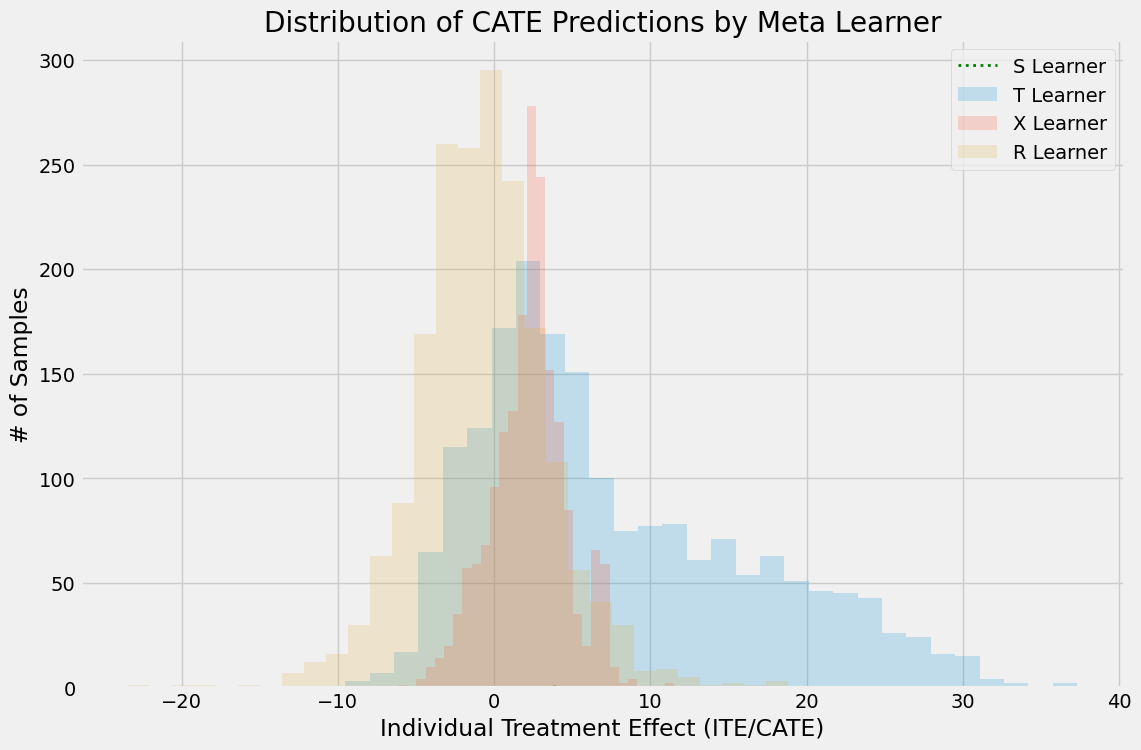

In [28]:
alpha=0.2
bins=30

plt.figure(figsize=(12,8))

plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)

plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')

plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')

_=plt.legend()


The ATE estimates the difference in the Life Expectancy between the two groups defined by the treatment (developed vs. developing countries).

Overall, the results suggest that there is a positive ATE, meaning that the life expectancy of developed countries is higher than developing countries. However, the magnitude of this effect varies significantly across the different models, with the T-Learner with XGBRegressor giving the highest estimate (~7.7 years) and R-Learner with XBGRegressor giving the lowest estimate (1.6 years - and it changes in every run).

The variations in the results of the different models are a reflection of the differing underlying assumptions and methodologies that they employ. To determine which model provides the most accurate estimate of the Average Treatment Effect (ATE), it would be ideal to compare the Mean Squared Error (MSE) between the actual ATE and the estimated ATE for each model. However, without the actual ATE data, this comparison cannot be made.

## Feature Importance

The feature importance is visualizaed using 
- *plot_importance*: it visualizes the feature importance for the treatment feature 'Status'. The values indicate the relative contributions of each feature to the prediction of the model.
- *SHAP plot*: SHAP value represent how each feature impacts the model output. Shapley values measures the contribution of each feature to the treatment effect prediction. The SHAP plot includes both the feature importance and the feature impacts. 

### S-Learner with LinearRegression 

S-Learner uses a single base learner with the treatment indicator included as a feature.

{'treatment_A': Diphtheria                         1.0
Polio                              0.0
Hepatitis B                        0.0
Total Expenditure                  0.0
Percentage Expenditure             0.0
Income Composition Of Resources    0.0
Population                         0.0
GDP                                0.0
dtype: float64} 

 {'treatment_A': Polio                              0.0
Diphtheria                         0.0
Hepatitis B                        0.0
Total Expenditure                  0.0
Percentage Expenditure             0.0
Income Composition Of Resources    0.0
Population                         0.0
GDP                                0.0
dtype: float64}


(0.0, 1.0)

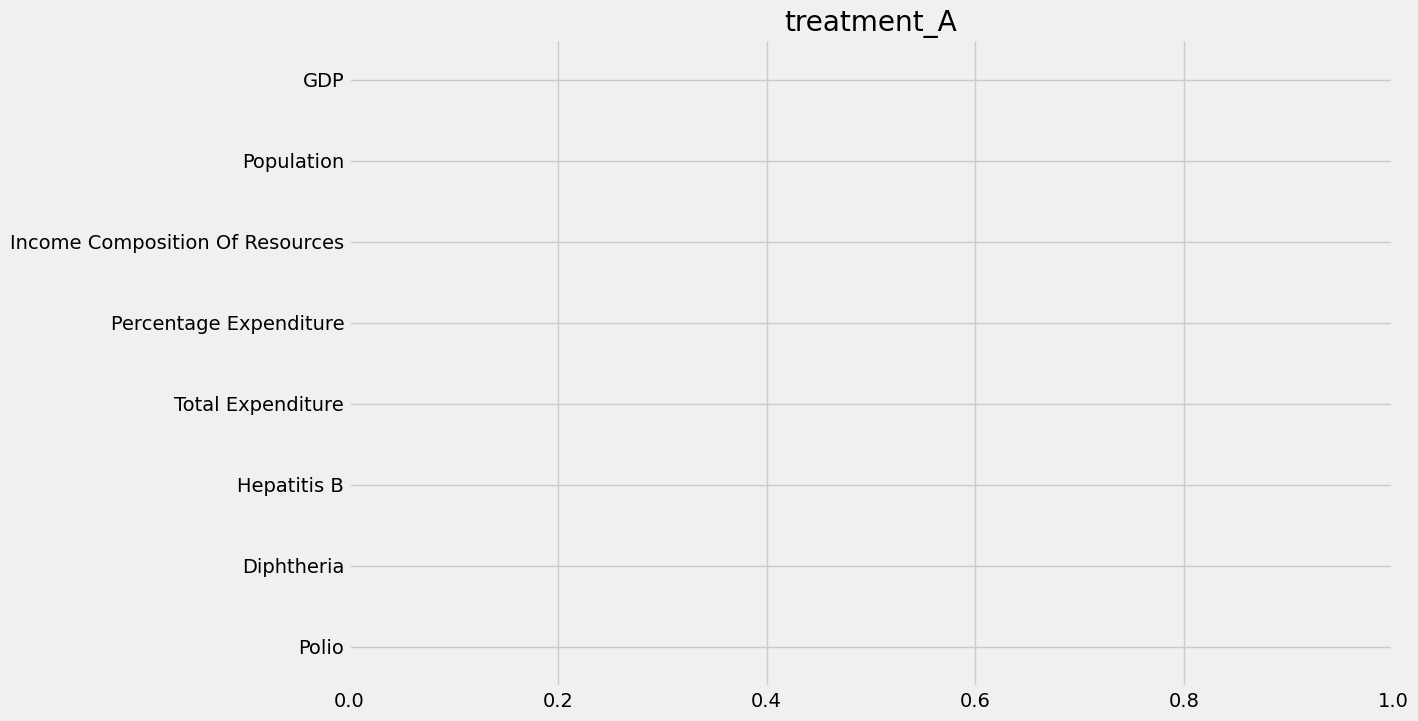

In [29]:
slearner_auto = learner_s.get_importance(X=X_c, tau=cate_s,normalize=True, 
                         method='auto', features=feature_names)

slearner_perm = learner_s.get_importance(X=X_c, tau=cate_s, normalize=True, 
                         method='permutation', features=feature_names)

print(slearner_auto, '\n\n', slearner_perm)

learner_s.plot_importance(X=X_c, tau=cate_s, normalize=True, 
                         method='permutation', features=feature_names)
plt.xlim([0,1])

Using 'auto' method, S_Learner determines that only "Diphtheria" has an importance to the prediction of the model when the country is developed. Using 'permutation' method, S-Learner determines that other variables have no effect on the outcome.

The difference in the feature importance results are due to the underlying assumption we made on the treatment and confounding features, and also the approaches different methods use to calculate.
- "auto" calculates importance based on estimator's default implementation
- "permutation" calculates importance based on mean decrease in accuracy when a feature column is permuted.
(See Reference: https://readthedocs.org/projects/causalml/downloads/pdf/latest/ page 67)

Except the sligh difference, both methods have determined that most of the control features as 0, meaning they don't have any effect on the outcome. For this reason, it is expected that the SHAP values will also be 0.

{'treatment_A': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}


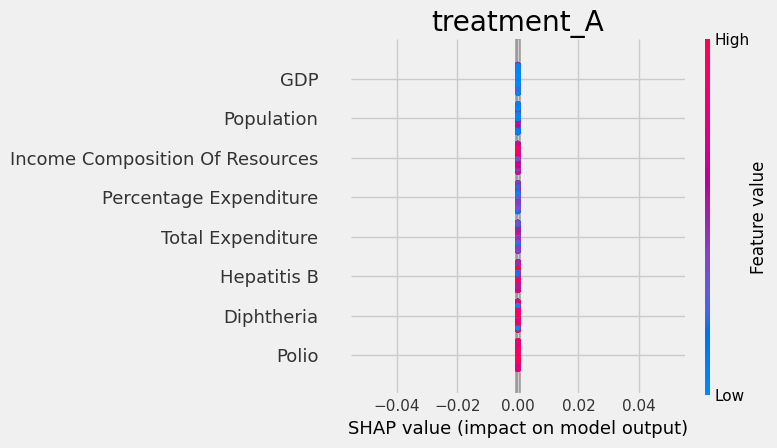

In [30]:
shap_slearner = learner_s.get_shap_values(X=X_c, tau=cate_s)
print(shap_slearner)

# Plot shap values with specifying shap_dict
learner_s.plot_shap_values( X=X_c, tau=cate_s, 
                            shape_dict=shap_slearner,
                            features=feature_names)

### T-Learner

T-Learner employs multiple base learners and combins their predictors to estimate the treatment effect. By training separate models for the treatment and control groups, the T-learner can better capture heterogeneity in the treatment effect.

{'treatment_A': Income Composition Of Resources    0.668917
Population                         0.096789
Percentage Expenditure             0.055707
GDP                                0.053495
Polio                              0.042851
Diphtheria                         0.036872
Total Expenditure                  0.028986
Hepatitis B                        0.016384
dtype: float64} 

 {'treatment_A': Income Composition Of Resources    0.913789
Population                         0.164172
GDP                                0.079860
Polio                              0.074243
Percentage Expenditure             0.066148
Diphtheria                         0.052358
Total Expenditure                  0.043653
Hepatitis B                        0.014347
dtype: float64}


(0.0, 1.0)

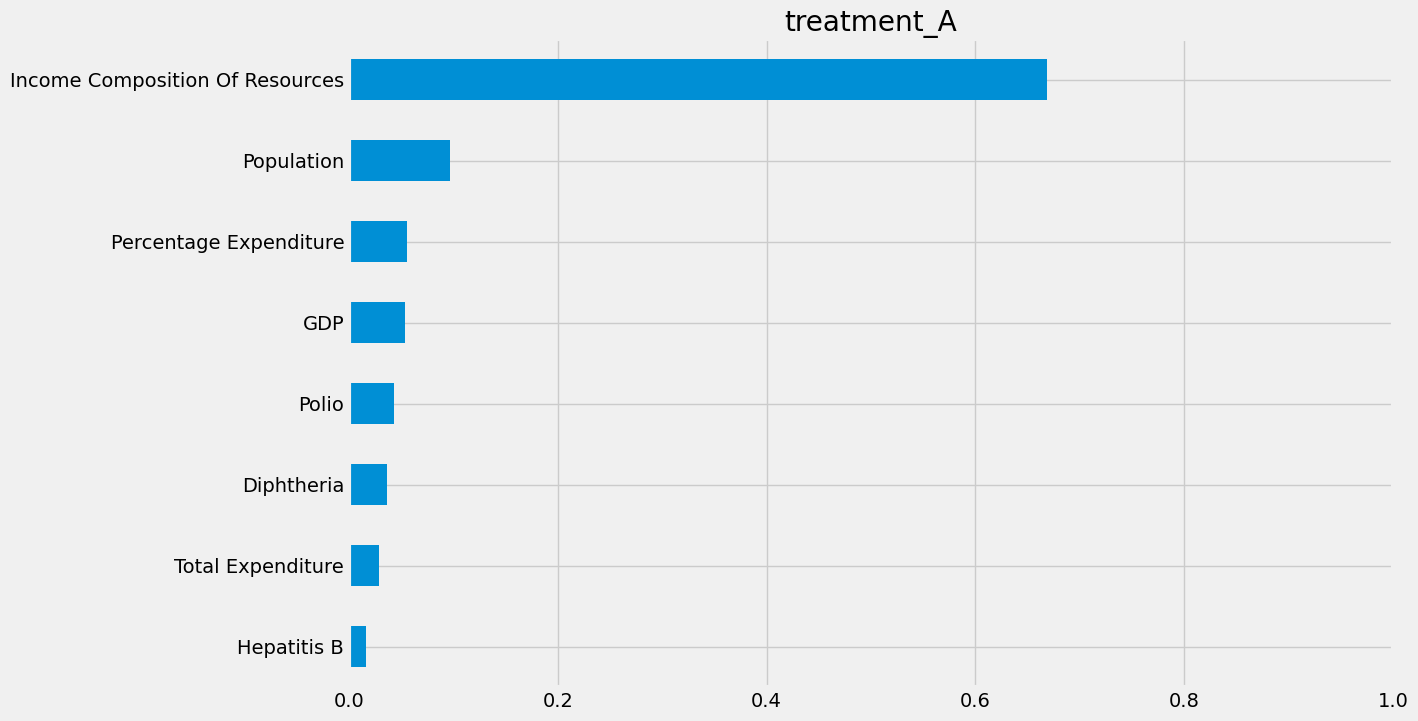

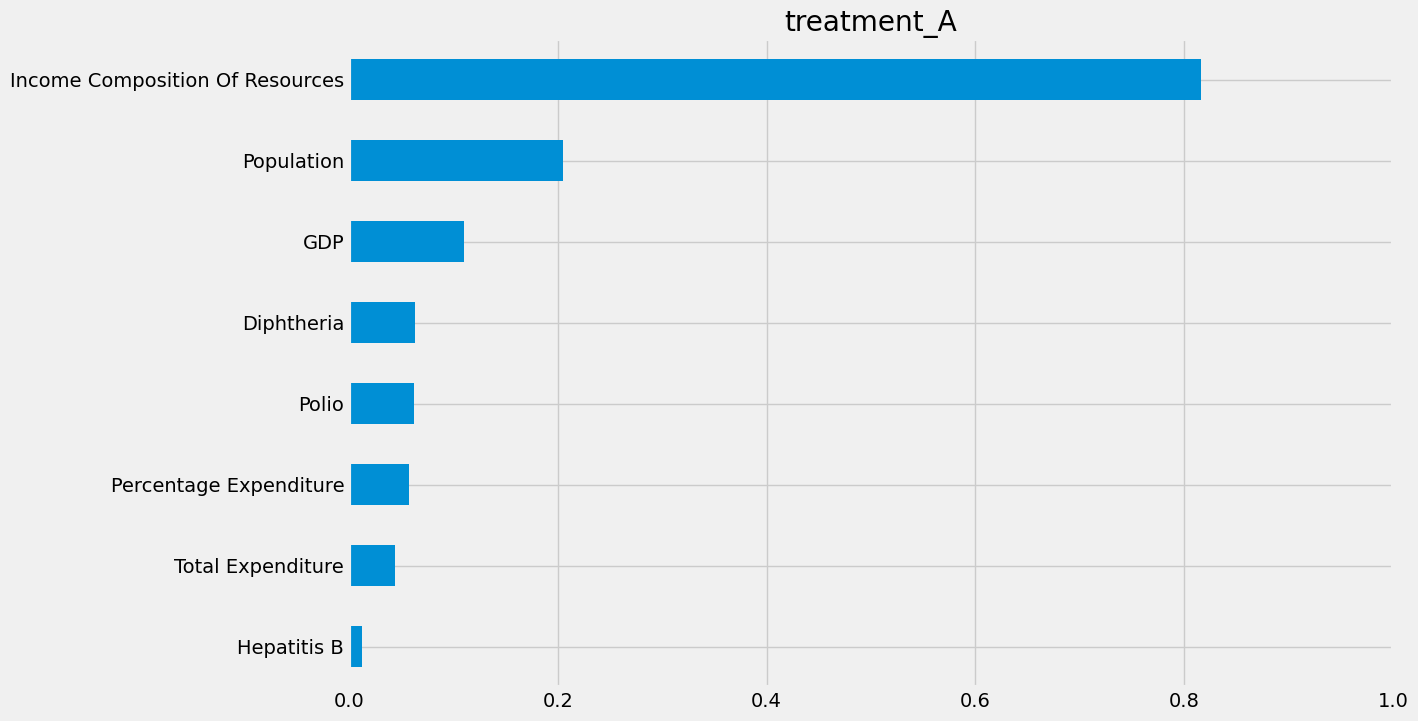

In [31]:
tlearner_auto = learner_t.get_importance(X=X_c, tau=cate_t,normalize=True, 
                         method='auto', features=feature_names)

tlearner_perm = learner_t.get_importance(X=X_c, tau=cate_t, normalize=True, 
                         method='permutation', features=feature_names)

print(tlearner_auto, '\n\n', tlearner_perm)

learner_t.plot_importance(X=X_c, tau=cate_t, normalize=True, 
                         method='auto', features=feature_names)
plt.xlim([0,1])

learner_t.plot_importance(X=X_c, tau=cate_t, normalize=True, 
                         method='permutation', features=feature_names)
plt.xlim([0,1])

{'treatment_A': array([[-9.79048263e-02, -4.61699948e-01,  4.74302185e-04, ...,
        -3.96802740e+00,  1.62846103e-01,  6.92192304e-01],
       [-1.00593737e+00, -5.73252661e-01, -3.37291914e-01, ...,
        -1.75529420e+00, -3.75708035e-01,  1.03731716e+00],
       [ 1.14868087e-01, -1.39297651e-01, -3.47049783e-01, ...,
         3.19051891e+00,  2.55273353e+00, -8.13935371e-02],
       ...,
       [-3.44184164e-01, -5.42088055e-01,  4.40388408e-01, ...,
        -4.72157081e+00, -5.21339096e-01, -3.23542089e-01],
       [-2.60433022e-01,  1.26313321e+00, -3.65069055e-02, ...,
         1.41107194e+00, -6.17059826e-01,  4.15608820e-01],
       [-3.75032191e-01, -1.78151778e-01, -1.32896200e-01, ...,
        -5.47947475e+00, -6.53006587e-01, -6.64103856e-01]])}


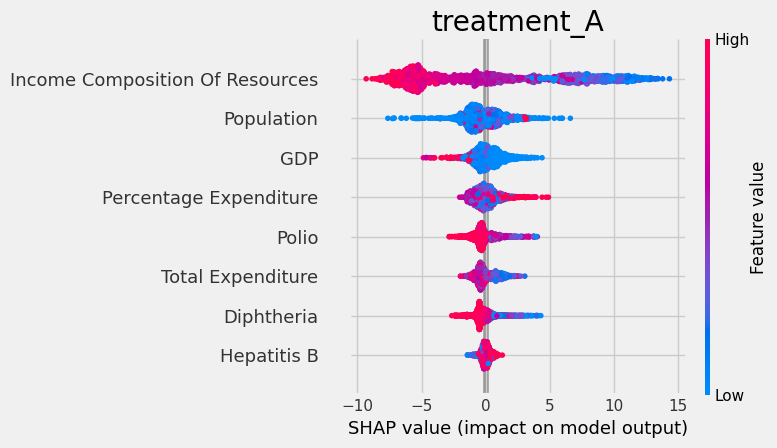

In [32]:
shap_tlearner = learner_t.get_shap_values(X=X_c, tau=cate_t)
print(shap_tlearner)

# Plot shap values with specifying shap_dict
learner_t.plot_shap_values( X=X_c, tau=cate_t, 
                            shape_dict=shap_tlearner,
                            features=feature_names)

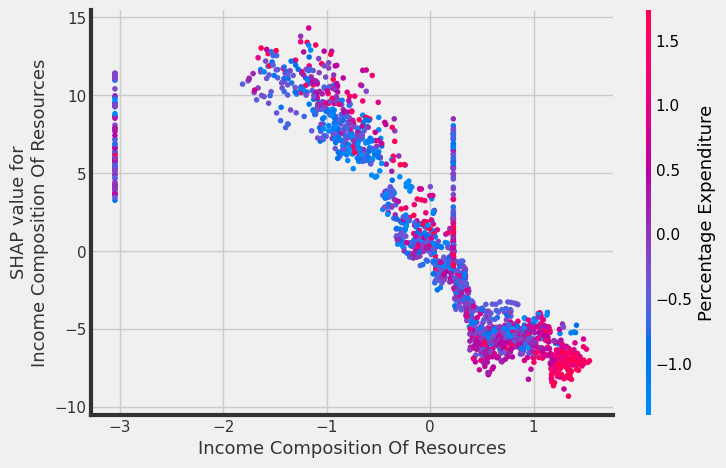

In [33]:
learner_t.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='Income Composition Of Resources', #1
                              X=X_c,
                              tau=cate_t,
                              interaction_idx='auto', #'auto search for feature with greatest approximate interaction
                              features=feature_names)

Even with two differnet methods, T-Learner produced similar results - with 'Income Composition Of Resources' having the largest impact on the treatment effect, followed by 'Population, 'GDP', and 'Percentage Expenditure'. This finding is in line with our assumption before. 

The shapley plot shows us Income Composition of Resources is associated with high and negative values on the CATE. In other words, when the income composition of resources is high, the average treatment effect is expected to be lower. Same with GDP, Polio, Total_Expenditure, Diphtheria. Most countries have a relatively low population, which does not affect much on the treatment.

The shap dependence plot tells us that 'Percentage Expenditure' interacts the most with 'Income Composition'. The plot shows there is an approximately linear but negative relationship between 'Income Composition' and the CATE.


### X-Learner

X-Learner is an extension of T-Learner. It "builds on the T-learner and uses each observation in the training set in an "X"-like shape".

"It is provably efficient when the number of units in one treatment group is much larger than in the other, and can exploit structural properties of the CATE function."

(Reference:https://arxiv.org/abs/1706.03461 )

{'treatment_A': Polio                              0.323209
Population                         0.199364
Income Composition Of Resources    0.181539
Percentage Expenditure             0.151359
GDP                                0.065727
Total Expenditure                  0.051614
Hepatitis B                        0.017307
Diphtheria                         0.009881
dtype: float64} 

 {'treatment_A': Income Composition Of Resources    0.502435
Polio                              0.441830
Percentage Expenditure             0.296398
Population                         0.291061
GDP                                0.093626
Total Expenditure                  0.065835
Hepatitis B                        0.028532
Diphtheria                         0.005430
dtype: float64}


(0.0, 1.0)

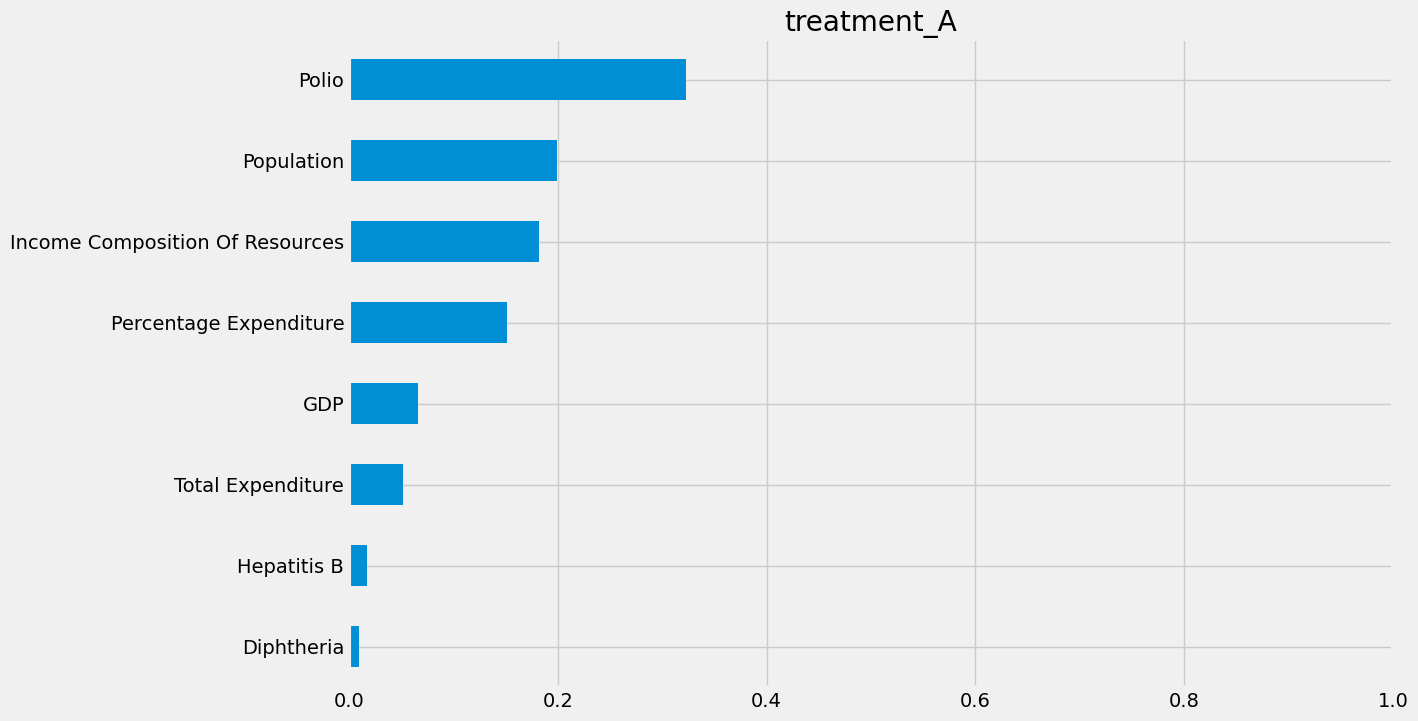

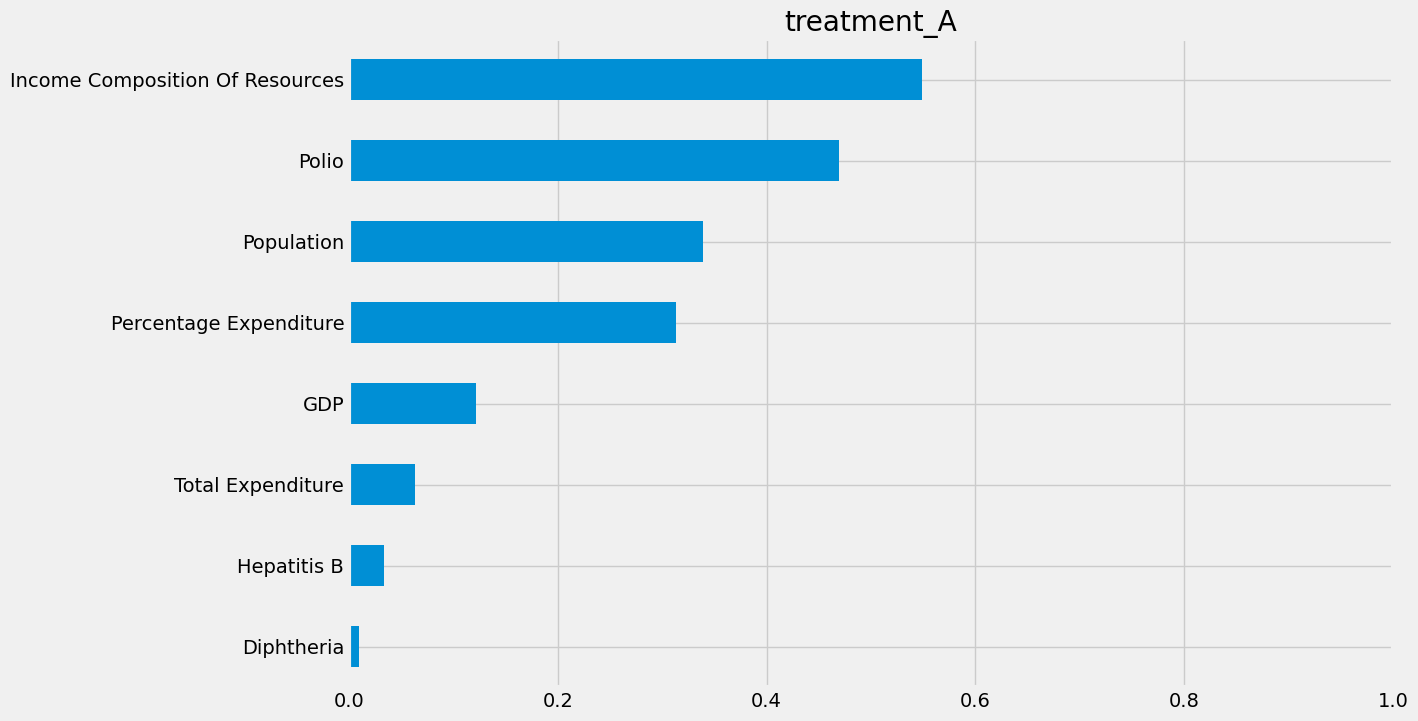

In [34]:
### X-Learner with XGBRegressor
xlearner_auto = learner_x.get_importance(X=X_c, tau=cate_x,normalize=True, 
                         method='auto', features=feature_names)

xlearner_perm = learner_x.get_importance(X=X_c, tau=cate_x, normalize=True, 
                         method='permutation', features=feature_names)

print(xlearner_auto, '\n\n', xlearner_perm)

learner_x.plot_importance(X=X_c, tau=cate_x, normalize=True, 
                         method='auto', 
                         features=feature_names)
plt.xlim([0,1])

learner_x.plot_importance(X=X_c, tau=cate_x, normalize=True, 
                         method='permutation', 
                         features=feature_names)
plt.xlim([0,1])

{'treatment_A': array([[ 0.20745858, -0.03338507, -0.18429601, ..., -0.59465764,
         1.6035042 ,  0.36756956],
       [ 0.45731938,  0.21334143, -0.01073628, ...,  0.82446371,
        -0.26972312,  0.0423651 ],
       [-0.43597021,  0.05467484,  0.26959551, ...,  0.31024281,
         1.23995123,  0.10889007],
       ...,
       [ 0.29930844,  0.19161327, -0.12690741, ..., -1.42885782,
        -0.72549204, -0.34572574],
       [-0.92629638, -0.06997761,  0.0728933 , ...,  0.65300084,
        -0.39315683,  0.1170774 ],
       [-0.36594619, -0.06967732, -0.01752706, ..., -0.57449028,
        -0.16326972, -0.67111243]])}


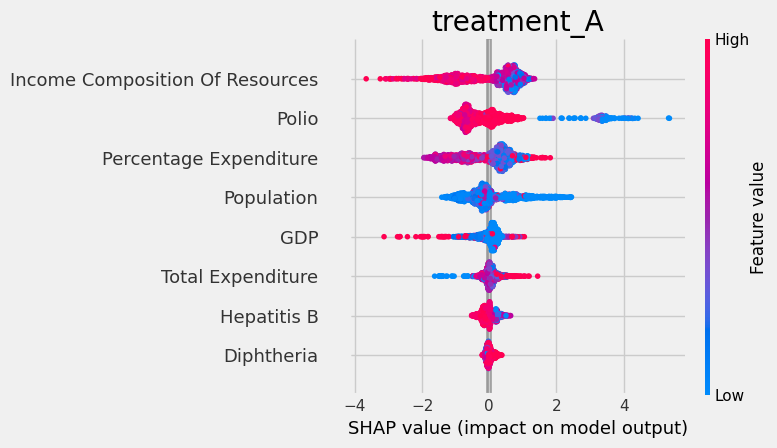

In [35]:
shap_xlearner = learner_x.get_shap_values(X=X_c, tau=cate_x)
print(shap_xlearner)

# Plot shap values with specifying shap_dict
learner_x.plot_shap_values( X=X_c, tau=cate_x, 
                            shape_dict=shap_xlearner,
                            features=feature_names)


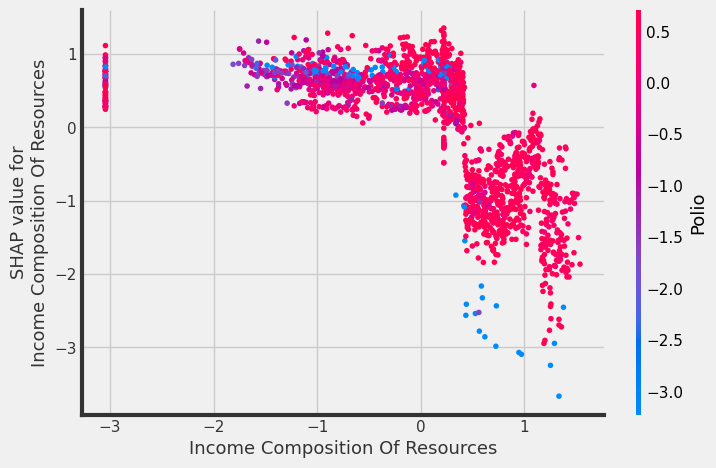

In [36]:
learner_x.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='Income Composition Of Resources',
                              X=X_c,
                              tau=cate_x,
                              interaction_idx='auto',
                              features=feature_names)

Using two different methods, X-Learner determined that Polio has the largest impact on 'Status'. Similar to the results generated from T-Learner, 'Income Composition Of Resources', 'Population, 'GDP', and 'Percentage Expenditure' also have certain impact on the treatment effect as well.

The shapley plot tell us that high value of Income Composition of Resources and Polio (immunization rate) are more likely to result in negative values on the treatment effect. The rest of the features have similar trend as they were showing in T-Learner's shap plot.

The shap dependence plot again indicates that 'Income Composition' has the most interaction with 'Polio', and it has a negative relationship with the treatment effect.


### R-Learner

R-Learner provides a general framework to estimate the heterogeneous treatment effect.
(Reference: https://arxiv.org/abs/1712.04912)

*It is worth noting that since R-Learner relies on random ssampling, it generates different estimates every time.(You might get a completely different result when running the same notebook).*

{'treatment_A': Percentage Expenditure             0.293995
GDP                                0.223117
Population                         0.200041
Total Expenditure                  0.104558
Income Composition Of Resources    0.081655
Hepatitis B                        0.045179
Diphtheria                         0.026885
Polio                              0.024569
dtype: float64} 

 {'treatment_A': GDP                                0.762267
Population                         0.444105
Percentage Expenditure             0.436844
Total Expenditure                  0.136217
Income Composition Of Resources    0.093059
Hepatitis B                        0.077439
Polio                              0.047376
Diphtheria                         0.030806
dtype: float64}


(0.0, 1.0)

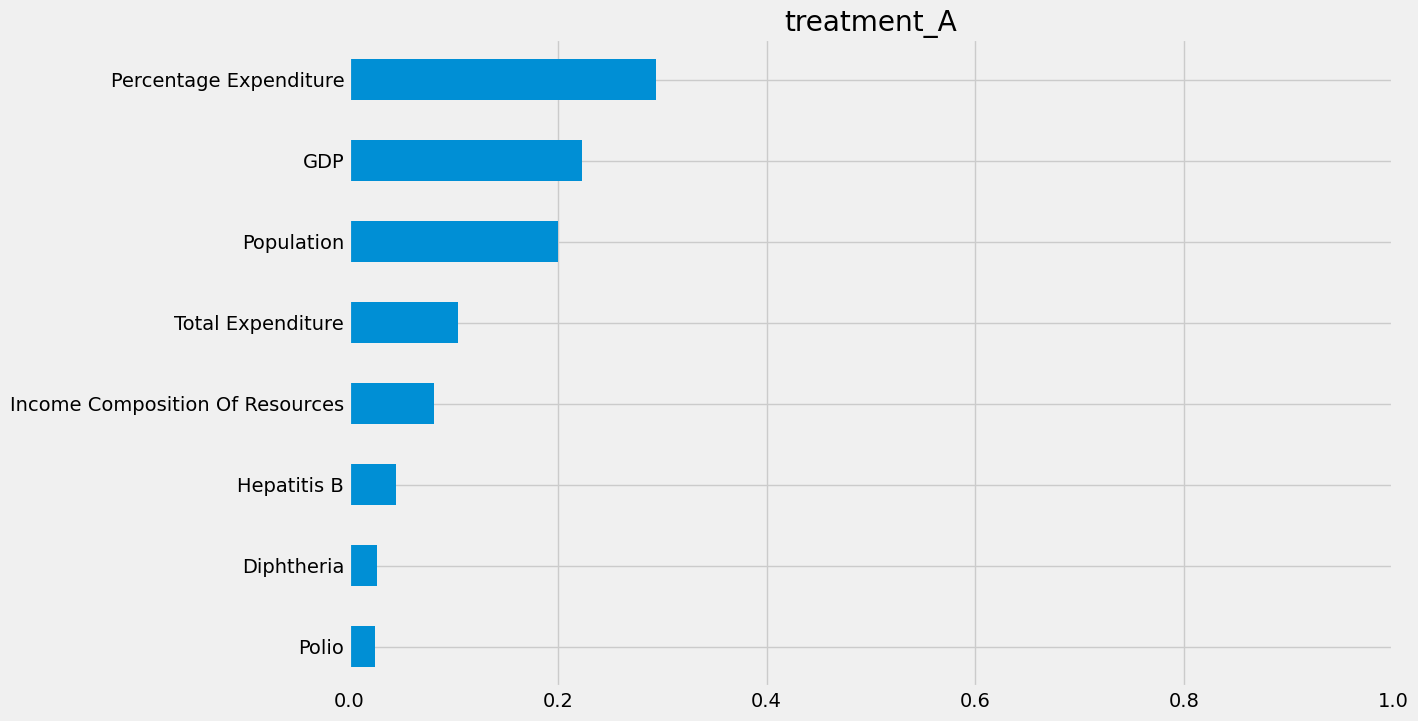

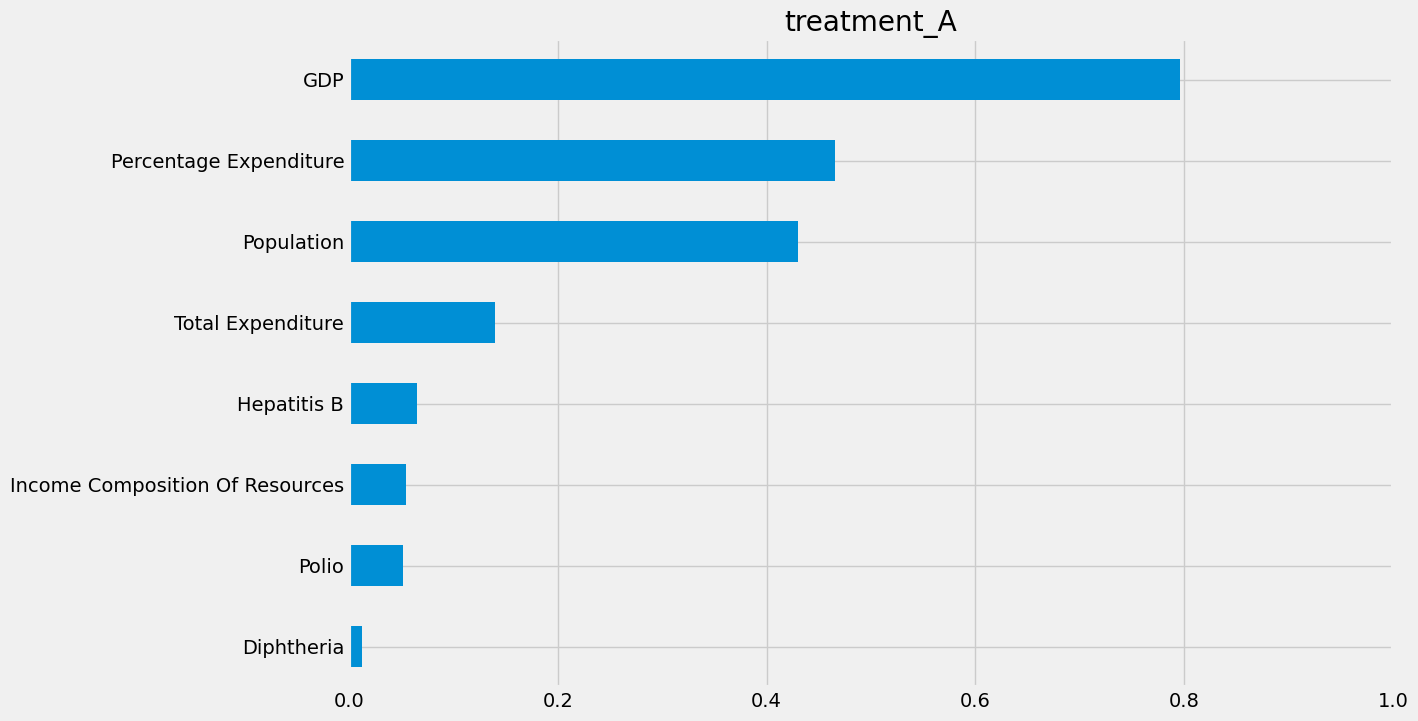

In [80]:
### R-Learner with XGBRegressor

rlearner_auto = learner_r.get_importance(X=X_c, tau=cate_r,normalize=True, 
                         method='auto', features=feature_names)

rlearner_perm = learner_r.get_importance(X=X_c, tau=cate_r, normalize=True, 
                         method='permutation', features=feature_names)

print(rlearner_auto, '\n\n', rlearner_perm)

learner_r.plot_importance(X=X_c, tau=cate_r, normalize=True, 
                         method='auto', 
                         features=feature_names)
plt.xlim([0,1])

learner_r.plot_importance(X=X_c, tau=cate_r, normalize=True, 
                         method='permutation', 
                         features=feature_names)
plt.xlim([0,1])

{'treatment_A': array([[ 0.26353405,  0.37036449, -0.91402148, ..., -0.02057705,
        -1.15644795, -1.01958812],
       [ 0.1146331 ,  0.26497265, -0.0936459 , ..., -0.03884517,
         1.17458485, -0.91163882],
       [-0.07558261, -0.29207364,  0.54058572, ..., -0.00749595,
        -1.30750781,  3.16243807],
       ...,
       [ 0.12917309,  0.12741085, -0.55180163, ..., -0.19537653,
         1.08348199, -2.9982565 ],
       [-0.22833361, -0.45591111, -0.02986059, ...,  0.10248783,
         1.26264077, -1.94181156],
       [ 0.12048883, -0.14375642,  0.02037668, ...,  0.09774979,
         1.20902907, -2.51777839]])}


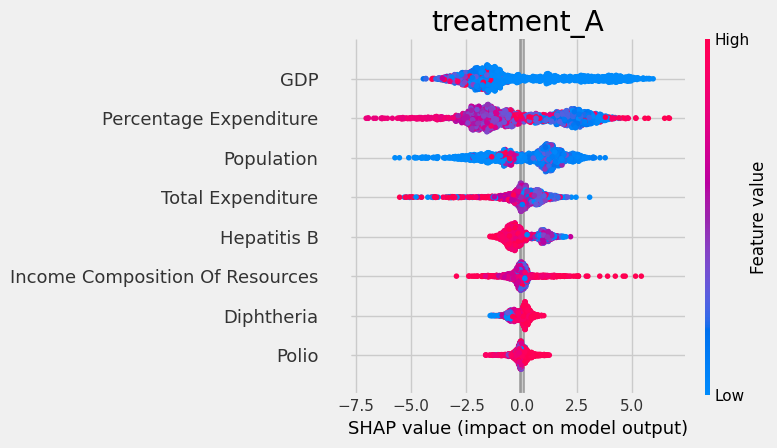

In [81]:
shap_rlearner = learner_r.get_shap_values(X=X_c, tau=cate_r)
print(shap_rlearner)

# Plot shap values with specifying shap_dict
learner_r.plot_shap_values( X=X_c, tau=cate_r, 
                            shape_dict=shap_rlearner,
                            features=feature_names)

ATE using R-Learner with XGBRegressor: -0.01646


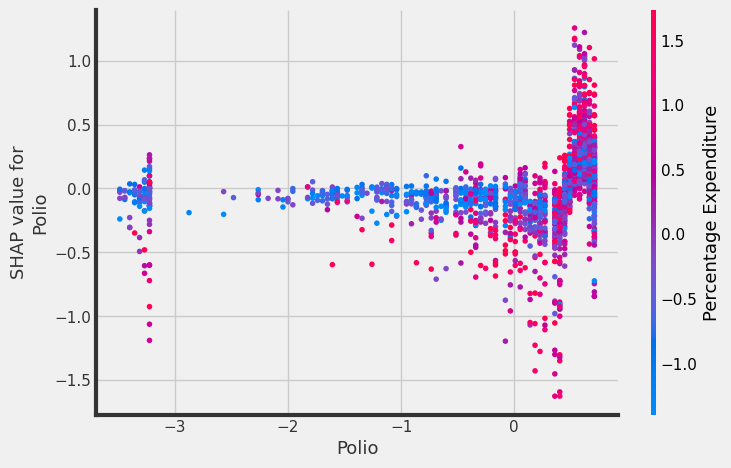

In [79]:
np.random.seed(12)
# R Learner without propensity score input
learner_r = BaseRRegressor(learner = XGBRegressor(),control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X_c, w_multi, y_c)
cate_r = learner_r.fit_predict(X_c, w_multi, y_c)
print('ATE using R-Learner with XGBRegressor: {}'.format(round(ate_r[0],5)))

learner_r.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=0,
                              X=X_c,
                              tau=cate_r,
                              interaction_idx='auto',
                              features=feature_names)

R-Learner shows a very different result, with GDP, Percentage Expenditure, and Population ranking the highest, while Income Composition rank relatively low. 

Running dependence plot using 'auto', the function automatically picks the most important feature and the one that it interacts the most with. In this case, 'Polio' and 'Percentage Expenditure'. It seems that with higher 'Percentage Expenditure' value, 'Polio' will also have a positive contribution. 

## Conclusion

My analysis of four different causal models has concluded that there is a positive causal relationship between a country's "Status" (i.e., if it is developed) and its life expectancy. The feature importances generated from these models also indicate that a country's development is influenced by factors such as its income composition, population, GDP, and expenditure percentage.

However, it's important to note that life expectancy is a complex issue that is influenced by many factors, such as demographics (e.g., age, gender, race), socio-economics (e.g., education, employment status), and health (e.g., access to healthcare, health behaviors). Despite this, we lack sufficient data to conduct a comprehensive analysis of these factors. Therefore, despite the positive relationship shown in the causal models, further investigation and consideration of other relevant factors is necessary to fully understand the causal effect of a country's development on its citizens' life expectancy.